# Итоговый проект (Выходцев Григорий)

1. Выберите датасет с изображениями из Вашей предметной области. Можно выбрать набор данных для задачи классификации или сегментации (это будет плюсом). Если Вы соберёте датасет самостоятельно, это также будет плюсом.
2.	Реализуйте три модели, решающие Вашу задачу:
  1. Первая модель должна быть самописная, по примеру из лекций, реализованная на PyTorch. Не обязательно делать её очень большой по числу слоёв. Фактически, это baseline.
  2. Вторая группа моделей должна быть развитием первой. Стоит добавить больше слоёв, skip-connection-ы, слои батчевой нормализации, dropout, dense-блоки (в качестве бонуса, будет плюсом), а также провести эксперименты с различными оптимизаторами и функциями активации.
  3. Третья группа моделей можно выбрать на основе готовых, и дообучить на Вашей задачу из п.1. Необходимо провести эксперименты с заморозкой различного числа fully-connected слоёв, добавить batchnorm и dropout.
3. По второй и третьей группе моделей стоит провести различные эксперименты согласно их описанию в п.2, после чего представить общую таблицу со сравнением качества работы всех моделей из 2.a-c.  

In [1]:
!pip install torchview
!pip install kagglehub

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms, utils
from torchvision.io import read_image
from PIL import Image
import kagglehub
from tqdm.notebook import tqdm
# from IPython.display import Image
from torchview import draw_graph


In [3]:
# # Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

# plt.ion()   # interactive mode

# Выбор датасета. Кастомный DataLoader

 https://www.kaggle.com/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/data

In [4]:
class CervCanc5KDataset(Dataset):
    def __init__(self, img_dir=None, train=True, transform=None):
        if img_dir is None:
            self.img_dir = kagglehub.dataset_download("prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed")
        else:
            self.img_dir = img_dir
        self.transform = transform
        self.img_annot = pd.DataFrame(columns=["image_path", "cancer_type", "is_cropped"])
        self._get_annot()
        self.classes_ = self.img_annot["cancer_type"].unique()


        data_train, data_test = train_test_split(self.img_annot, test_size=0.2, random_state=42, stratify=self.img_annot["cancer_type"])
        if train:
            self.img_annot = data_train
        else:
            self.img_annot = data_test
        self.img_annot.reset_index(inplace=True, drop=True)


    def _get_annot(self):
        cancer_types = os.listdir(self.img_dir)
        for type in cancer_types:
            files = os.listdir(f"{self.img_dir}/{type}/{type}")
            type_val = type.lstrip("im_")
            for file in files:
                if file.endswith(".bmp"):
                    self.img_annot.loc[len(self.img_annot.index)] = [f"{self.img_dir}/{type}/{type}/{file}", type_val, False]
            if "CROPPED" in files:
                for file in os.listdir(f"{self.img_dir}/{type}/{type}/CROPPED"):
                    if file.endswith(".bmp"):
                        self.img_annot.loc[len(self.img_annot.index)] = [f"{self.img_dir}/{type}/{type}/CROPPED/{file}", type_val, True]

    def __len__(self):
        return len(self.img_annot)

    def __getitem__(self, idx):
        img_path = self.img_annot["image_path"][idx]
        image = Image.open(img_path).convert("RGB")

        label = self.img_annot["cancer_type"][idx]
        label_idx  = self.classes_.tolist().index(label)

        # is_cropped = self.img_annot["is_cropped"][idx]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

In [5]:
transform = transforms.Compose([
         transforms.Resize((150, 150)),
         transforms.ToTensor()
])

In [6]:
data_train = CervCanc5KDataset(train=True, transform=transform)
data_test = CervCanc5KDataset(train=False, transform=transform)

100%|██████████| 6.40G/6.40G [01:20<00:00, 85.8MB/s]

Extracting files...


In [7]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=16, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=16, shuffle = False, pin_memory=True, num_workers=2)

# Функции для обучения моделей и визулизации результатов

In [8]:
import time
import torch
import numpy as np

def train_model(model, train_loader, test_loader, loss_fn, opt, n_epochs: int):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        # Training phase
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                val_loss_value = loss_fn(y_pred, y_batch)
                ep_val_loss.append(val_loss_value.item())

                y_pred = y_pred.argmax(dim=1)
                accuracy = (y_pred == y_batch).float().mean().item()
                ep_val_accuracy.append(accuracy)

        # Logging epoch results
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [9]:
def plot_results(train_loss, val_loss, val_accuracy, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title, fontsize=15, fontweight="bold")

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()
    axes[0].set_xlabel('Epoch')

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylim([0,1])
    axes[1].axhline(y = 0.5, color = 'r', linestyle = '--')

    plt.show()


In [10]:
all_results = {}

# 1) Обучение baseline модели

In [11]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=8, stride=3)
        self.conv2 = nn.Conv2d(10, 3, kernel_size=8, stride=3)
        self.fc = nn.Linear(588, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc(x)
        return x

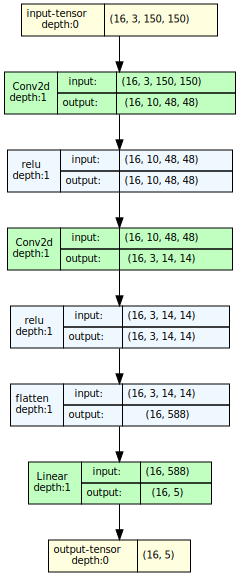

In [12]:
model_graph = draw_graph(BaseModel(), input_size=(16,3,150,150), save_graph=True, filename='baseline.png')

model_graph.visual_graph

In [13]:
base_model = BaseModel()
loss_fn = torch.nn.CrossEntropyLoss() #Select a loss function
optimizer = torch.optim.Adam(base_model.parameters())

In [14]:
train_loss, val_loss, val_accuracy = train_model(base_model, train_loader, test_loader, loss_fn, optimizer, n_epochs=10)

Epoch 1 of 10 took 73.268s
	  training loss: 1.363883
	validation loss: 1.248975
	validation accuracy: 0.452
Epoch 2 of 10 took 70.202s
	  training loss: 1.225984
	validation loss: 1.232713
	validation accuracy: 0.522
Epoch 3 of 10 took 66.781s
	  training loss: 1.177423
	validation loss: 1.137883
	validation accuracy: 0.524
Epoch 4 of 10 took 64.141s
	  training loss: 1.146847
	validation loss: 1.140053
	validation accuracy: 0.551
Epoch 5 of 10 took 61.901s
	  training loss: 1.094281
	validation loss: 1.071823
	validation accuracy: 0.551
Epoch 6 of 10 took 68.389s
	  training loss: 1.076697
	validation loss: 1.090902
	validation accuracy: 0.579
Epoch 7 of 10 took 62.591s
	  training loss: 1.038734
	validation loss: 1.128765
	validation accuracy: 0.541
Epoch 8 of 10 took 61.007s
	  training loss: 1.043088
	validation loss: 1.018065
	validation accuracy: 0.590
Epoch 9 of 10 took 67.788s
	  training loss: 1.023434
	validation loss: 1.044857
	validation accuracy: 0.588
Epoch 10 of 10 took

In [15]:
all_results['Baseline'] = [train_loss, val_loss, val_accuracy]

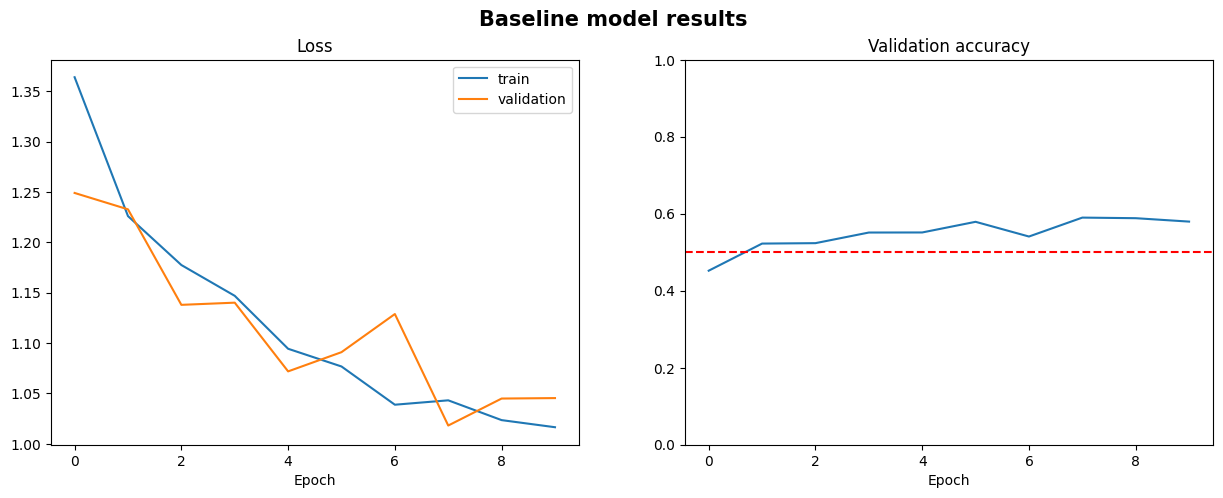

In [16]:
plot_results(train_loss, val_loss, val_accuracy, "Baseline model results")

# 2) Более продвинтуая архитектура с Dense блоками

Архитектура одна, поменять оптимизатор, добавить batchnorm

3 - 4 перебора

DenseNet, BatchNorm

In [17]:
class DenseLayer(nn.Module):

    def __init__(self,in_channels, k, f_act):
        super(DenseLayer,self).__init__()

        self.BN = nn.BatchNorm2d(num_features = in_channels)
        self.conv = nn.Conv2d(in_channels=in_channels , out_channels=k , kernel_size=3 , stride=1 , padding=1)
        self.f_act = f_act

    def forward(self,x):
        xin = x
        x = self.BN(x)
        x = self.f_act(x)
        x = self.conv(x)
        x = torch.cat([xin,x],1)
        return x

class DenseBlock(nn.Module):
    def __init__(self, n_layer, in_channels, k, f_act):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([DenseLayer(in_channels + k * i, k, f_act) for i in range(n_layer)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, n_layer, in_channels, k, f_act, n_classes=5):
        super(DenseNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=k, kernel_size=7 ,stride=2 ,padding=3)
        self.BN = nn.BatchNorm2d(num_features = k)
        self.f_act = f_act
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dense_block = DenseBlock(n_layer, k, k, self.f_act)
        self.average_pool = nn.AdaptiveAvgPool2d(2)
        self.fc = nn.Linear((k + k * n_layer) * (2 * 2), n_classes)

    def forward(self, x):
        x = self.f_act(self.BN(self.conv(x)))
        x = self.maxpool(x)
        x = self.dense_block(x)
        x = self.average_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x


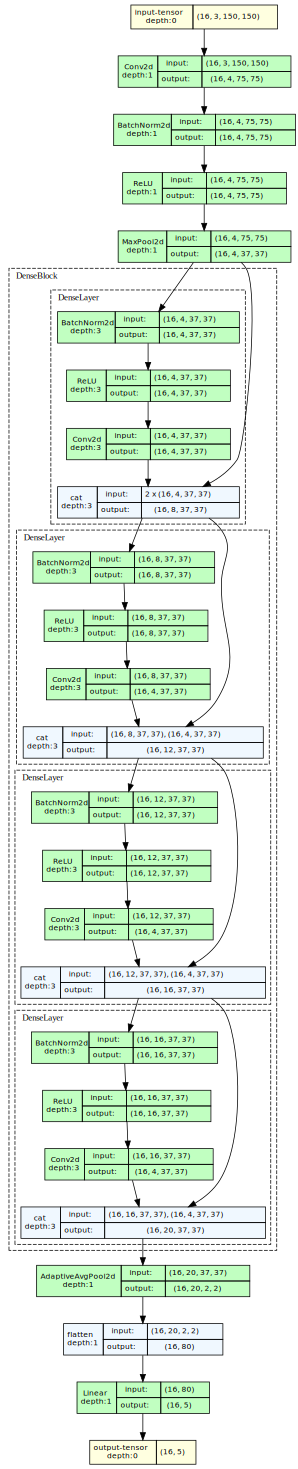

In [18]:
f_act = nn.ReLU()
model = DenseNet(4, 3, 4, f_act)
model_graph = draw_graph(model, input_size=(16,3,150,150), expand_nested=True, save_graph=True,filename="Dense_net_arch")
model_graph.visual_graph

In [19]:
# f_act = nn.ReLU()
# model = DenseNet(4, 3, 4, f_act)
# tensor = data_train[0][0]
# tensor.unsqueeze_(0)

# model(tensor)

In [20]:
activations = {"ReLU": nn.ReLU(), "LeakyReLU":nn.LeakyReLU()}
optimizers = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}

In [ ]:
for f_act in tqdm(activations):
    for optimizer_type in tqdm(optimizers):
        advance_model = DenseNet(n_layer=7, in_channels=3, k=12, f_act=activations[f_act])
        loss_fn = torch.nn.CrossEntropyLoss() #Select a loss function
        optimizer = optimizers[optimizer_type](advance_model.parameters())
        train_loss, val_loss, val_accuracy = train_model(advance_model, train_loader, test_loader, loss_fn, optimizer, n_epochs=10)
        all_results[f"DenseBlock_{optimizer_type}_{f_act}"] = [train_loss, val_loss, val_accuracy]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 of 10 took 138.183s
	  training loss: 1.040899
	validation loss: 0.952214
	validation accuracy: 0.631
Epoch 2 of 10 took 125.345s
	  training loss: 0.878719
	validation loss: 0.889694
	validation accuracy: 0.649
Epoch 3 of 10 took 136.538s
	  training loss: 0.832095
	validation loss: 0.758262
	validation accuracy: 0.723
Epoch 4 of 10 took 129.513s
	  training loss: 0.810629
	validation loss: 0.818242
	validation accuracy: 0.677
Epoch 5 of 10 took 125.701s
	  training loss: 0.759890
	validation loss: 0.896090
	validation accuracy: 0.686
Epoch 6 of 10 took 127.336s
	  training loss: 0.716109
	validation loss: 0.595914
	validation accuracy: 0.784
Epoch 7 of 10 took 124.612s
	  training loss: 0.722307
	validation loss: 0.636704
	validation accuracy: 0.767
Epoch 8 of 10 took 133.470s
	  training loss: 0.680211
	validation loss: 0.575560
	validation accuracy: 0.775
Epoch 9 of 10 took 126.306s
	  training loss: 0.652298
	validation loss: 0.649290
	validation accuracy: 0.733
Epoch 10 o

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 of 10 took 134.911s
	  training loss: 1.051912
	validation loss: 0.976169
	validation accuracy: 0.610
Epoch 2 of 10 took 138.341s
	  training loss: 0.873927
	validation loss: 0.786541
	validation accuracy: 0.684
Epoch 3 of 10 took 127.587s
	  training loss: 0.829793
	validation loss: 1.544163
	validation accuracy: 0.535
Epoch 4 of 10 took 129.676s
	  training loss: 0.812663
	validation loss: 0.633211
	validation accuracy: 0.778
Epoch 5 of 10 took 130.323s
	  training loss: 0.767372
	validation loss: 0.637979
	validation accuracy: 0.754
Epoch 6 of 10 took 127.822s
	  training loss: 0.722535
	validation loss: 1.412286
	validation accuracy: 0.608
Epoch 7 of 10 took 140.041s
	  training loss: 0.701982
	validation loss: 0.607513
	validation accuracy: 0.790
Epoch 8 of 10 took 127.738s
	  training loss: 0.665942
	validation loss: 1.182241
	validation accuracy: 0.640
Epoch 9 of 10 took 127.080s
	  training loss: 0.650824
	validation loss: 1.322322
	validation accuracy: 0.602
Epoch 10 o

# 3) Использование предобученной нейросети

In [ ]:
model_graph = draw_graph(model, input_size=(16,3,150,150), expand_nested=True, save_graph=True,filename="DenseNet121")

In [ ]:
from torchvision import models
densenet121 = models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 123MB/s]


In [ ]:
class New_DenseNet121(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.pred_model = densenet121
        for param in self.pred_model.features.parameters():
            param.requires_grad = False

        num_features = self.pred_model.classifier.in_features
        self.pred_model.classifier = nn.Linear(num_features, n_classes)

    def forward(self, x):
        return self.pred_model(x)

# check requires_grad=False

# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

In [ ]:
# model = New_DenseNet121()
# tensor = data_train[0][0]
# tensor.unsqueeze_(0)

# model(tensor)

In [ ]:
pred_model = New_DenseNet121()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pred_model.parameters())

In [ ]:
train_loss, val_loss, val_accuracy = train_model(pred_model, train_loader, test_loader, loss_fn, optimizer, n_epochs=10)

Epoch 1 of 10 took 583.775s
	  training loss: 0.808703
	validation loss: 0.496249
	validation accuracy: 0.836
Epoch 2 of 10 took 642.998s
	  training loss: 0.538325
	validation loss: 0.400729
	validation accuracy: 0.872
Epoch 3 of 10 took 635.771s
	  training loss: 0.469892
	validation loss: 0.395160
	validation accuracy: 0.858
Epoch 4 of 10 took 642.255s
	  training loss: 0.424941
	validation loss: 0.336543
	validation accuracy: 0.884
Epoch 5 of 10 took 645.264s
	  training loss: 0.405981
	validation loss: 0.330355
	validation accuracy: 0.879


In [ ]:
all_results["Predtrained_DenseNet121"] = [train_loss, val_loss, val_accuracy]

# Итоговые результаты

In [ ]:
import pickle

with open("all_results.pkl", "wb") as file:
    pickle.dump(all_results, file)

with open("all_results.pkl", "rb") as file:
    all_results = pickle.load(file)

In [ ]:
for key, value in all_results.items():
    plot_results(value[0], value[1], value[2], key)

In [ ]:
data = [(key, np.median(value[2])) for key, value in all_results.items()]
df = pd.DataFrame(data, columns=["model", "median_accuracy"])
df.sort_values(by="median_accuracy", ascending=False)

In [ ]:
for key, value in all_results.items():
    plt.plot(value[2], label=key)
plt.legend()
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy for all models")
plt.show()